## Prelim Prep/Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import pmdarima as pm
from pmdarima.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_excel("SupplyChain_TimeSeriesData.xlsx")

In [3]:
# Using the Pandas bdate_range function, we calculate number of days taken to complete order (excluding weekends)
df['scheduled_duration_nowkend'] = df.apply(lambda row: pd.bdate_range( row['Schedule Start Date'], row['Schedule Finish Date']).shape[0] \
                                            if not pd.isna(row['Schedule Start Date']) and not pd.isna(row['Schedule Finish Date']) else np.nan, axis=1 )
df['actual_duration_nowkend'] = df.apply(lambda row: pd.bdate_range( row['Confirmation Start Date'], row['Usage Decision Date']).shape[0] \
                                         if not pd.isna(row['Confirmation Start Date']) and not pd.isna(row['Usage Decision Date']) else np.nan, axis=1 )

# Drop null values
df = df.dropna(subset=['Confirmation Start Date', 'Usage Decision Date'])

# Drop dates before 2016
orders = df[df['Confirmation Start Date'] < pd.Timestamp(2017,1,1)]['Order'].unique()
df = df[~df['Order'].isin(orders)]

df.head()

,Order,Material,Batch,Group,MaterialCategory,Total order quantity,Unit,Quantity of goods received,Schedule Start Date,Schedule Finish Date,Confirmation Start Date,First Goods Movement Date,Goods Receipt Date,Usage Decision Date,dur,scheduled_duration_nowkend,actual_duration_nowkend
478,101863,100001706,B174,138,13,14.0,PC,14.0,2016-11-21,2016-11-29,2017-02-22,2016-11-18,2016-11-18,2016-11-21,-68,7,0
549,101986,100001706,B203,138,13,14.0,PC,14.0,2016-11-23,2016-12-01,2017-02-22,2016-11-23,2016-11-23,2016-11-23,-66,7,0
705,101990,100001705,B216,138,13,42.0,PC,42.0,2016-11-30,2016-12-06,2017-02-22,2016-11-30,2016-11-30,2016-12-01,-60,5,0
765,102129,100002226,B233,138,1,30000.0,ML,30000.0,2016-11-29,2016-12-02,2017-02-22,2016-11-29,2016-11-29,2016-12-05,-58,4,0
766,101992,100001705,B224,138,13,102.0,PC,102.0,2016-12-05,2016-12-09,2017-02-22,2016-12-05,2016-12-05,2016-12-05,-58,5,0


In [4]:
#Change the units to ML
df.loc[df["Unit"] == "µL", "Total order quantity"] = df["Total order quantity"]/1000
df.loc[df["Unit"] == "µL", "Unit"] = "ML"

df.loc[df["Unit"] == "L", "Total order quantity"] = df["Total order quantity"] * 1000
df.loc[df["Unit"] == "L", "Unit"] = "ML"

display(df.shape)
display(df.head())

(31961, 17)

,Order,Material,Batch,Group,MaterialCategory,Total order quantity,Unit,Quantity of goods received,Schedule Start Date,Schedule Finish Date,Confirmation Start Date,First Goods Movement Date,Goods Receipt Date,Usage Decision Date,dur,scheduled_duration_nowkend,actual_duration_nowkend
478,101863,100001706,B174,138,13,14.0,PC,14.0,2016-11-21,2016-11-29,2017-02-22,2016-11-18,2016-11-18,2016-11-21,-68,7,0
549,101986,100001706,B203,138,13,14.0,PC,14.0,2016-11-23,2016-12-01,2017-02-22,2016-11-23,2016-11-23,2016-11-23,-66,7,0
705,101990,100001705,B216,138,13,42.0,PC,42.0,2016-11-30,2016-12-06,2017-02-22,2016-11-30,2016-11-30,2016-12-01,-60,5,0
765,102129,100002226,B233,138,1,30000.0,ML,30000.0,2016-11-29,2016-12-02,2017-02-22,2016-11-29,2016-11-29,2016-12-05,-58,4,0
766,101992,100001705,B224,138,13,102.0,PC,102.0,2016-12-05,2016-12-09,2017-02-22,2016-12-05,2016-12-05,2016-12-05,-58,5,0


In [5]:
# Get rid of negative durations
df = df[df['dur']>0]
# Set indices
df.set_index("Confirmation Start Date", inplace = True)
# Add frequency checkers for later
df["month"] = df.index.to_period("M")
df["quarter"] = df.index.to_period("Q")
df["week"] = df.index.to_period("W")

## Grouping
Groups based on the assumption that the hierarchy is category -> group -> material from least precise to most precise. Starts by determining all possible groupings of material that have enough data to make a forecast, then moves to group, and finally to category. This information is stored in dictionaries mat_trend, group_trend, cat_trend. To access these items easier the lists mats, groups and cats are created which have the names of all the materials, groups and categories within the respective dictionaries. For example mat_trend[mats[0]] would access the first item within the mat_trend dictionary.

In [6]:
import copy
types = ['Material', 'Group', 'MaterialCategory']
dics = {'mat_trend' : {}, 'group_trend' : {}, 'cat_trend' : {}}
thresholds = [75,75,50]


for (typ, dic, thresh) in zip(types, dics, thresholds):
    # Group 
    gr = df.groupby(typ)
    groups = dict(list(gr))
    # Checks if group has enough data
    for x in groups:
        single = groups[x]
        if len(single) > thresh:
            dics[dic][x] = single

# Transfer back over for ease later            
mat_trend = dics['mat_trend']
group_trend = dics['group_trend']
cat_trend = dics['cat_trend']

# Lists of keys
mats = list(mat_trend.keys())
groups = list(group_trend.keys())
cats = list(cat_trend.keys())

# Note to self: 48, 42, 11
print("Material groups that have enough data: %d" % len(mat_trend))
print("Group groups that have enough data: %d" % len(group_trend))
print("Category groups that have enough data: %d" % len(cat_trend))

Material groups that have enough data: 48
Group groups that have enough data: 41
Category groups that have enough data: 11


## Get Rid of Outliers
Groupings from previous cell taken and trimmed to get rid of outliers. New groupings are put into mat_trend_trim, group_trend_trim, cat_trend_trim

In [7]:
# Returns group with outliers removed using specified method. Args:
# Group: data fed in
# Time: ('total') Want to remove outliers from total df, or ('month') remove outliers per month, ('quarter') per quarter
# Method: specify iqr or z-score method
def remove_outliers(group, time, method):
    if(time == 'total'):
        if method == 'zscore':
            group['zscore'] = np.abs(stats.zscore(group['actual_duration_nowkend']))
            group = group[group['zscore'] < 3]
            group.sort_values(by='Usage Decision Date')
            return group
        elif method == 'iqr':
            q1 = group.quantile(0.25)['actual_duration_nowkend']
            q2 = group.quantile(0.50)['actual_duration_nowkend']
            q3 = group.quantile(0.75)['actual_duration_nowkend']

            IQR = q3 - q1
            lower = q1 - 1.5*IQR
            upper = q3 + 1.5*IQR

            # Removes outliers
            group = group[(group['actual_duration_nowkend'] < upper) & (group['actual_duration_nowkend'] > lower)]
            return group
        
    else:
        updated_group = pd.DataFrame() 
        
        if time == 'month':
            dates = pd.unique(group["month"])
        if time == 'quarter':
            dates = pd.unique(group["quarter"])
        for period in dates:
            df_quarter = group.loc[group[time] == period]
            if method == 'zscore':
                df_quarter['zscore'] = np.abs(stats.zscore(df_quarter['actual_duration_nowkend']))
                temp = df_quarter.loc[df_quarter['zscore'] < 3]
            elif method == 'iqr':
                q1 = df_quarter.quantile(0.25)['actual_duration_nowkend']
                q2 = df_quarter.quantile(0.50)['actual_duration_nowkend']
                q3 = df_quarter.quantile(0.75)['actual_duration_nowkend']

                IQR = q3 - q1
                lower = q1 - 1.5*IQR
                upper = q3 + 1.5*IQR

                # Removes outliers
                temp = df_quarter[(df_quarter['actual_duration_nowkend'] < upper) & (df_quarter['actual_duration_nowkend'] > lower)]
            updated_group = updated_group.append(temp)   
        updated_group = updated_group.sort_values(by='Usage Decision Date')
        return updated_group

In [8]:
lists = [mats, groups, cats]
dics = [mat_trend, group_trend, cat_trend]
types = ['Material', 'Group', 'MaterialCategory']

# new dictionaries to copy over data without outliers
mat_trend_trim = {}
group_trend_trim = {}
cat_trend_trim = {}
new_dics = [mat_trend_trim, group_trend_trim, cat_trend_trim]


# Track amount of datapoints deleted
deltas = []
for (typ, lis, olddic, newdic) in zip(types, lists, dics, new_dics):
    delta = []
    for x in lis:
        group = olddic[x]
        start = len(group)
        # Get rid of outliers - first does overall iqr then does moving iqr
        group = remove_outliers(group, 'total', 'zscore')
        group = remove_outliers(group, 'quarter', 'iqr')
        # calculate datapoints lost
        end = len(group)
        delta.append([x, start, end, start-end, (100*(start-end)/start)])
        # Combine all datapoints in same month for consistent frequency
        group_resample = group.resample("W").mean()
        group_resample["actual_duration_nowkend"] = group_resample["actual_duration_nowkend"].fillna(method = "ffill")
        newdic[x] = group_resample
    #append to overall list    
    deltas.append(pd.DataFrame(delta, columns=[typ, 'Start', 'End', 'Delta', 'Percentlost']))

# Updates lists of keys
mats_trim = list(mat_trend_trim.keys())
groups_trim = list(group_trend_trim.keys())
cats_trim = list(cat_trend_trim.keys())
    

In [9]:
# Shows data loss with outlier method 
# 0 = Materials, 1 = Group, 2 = MaterialCategory
print('Materials outlier mean data percent lost: %0.2f' % deltas[0]['Percentlost'].mean())
print('Groups outlier mean data percent lost: %0.2f' % deltas[1]['Percentlost'].mean())
print('MaterialCategory outlier mean data percent lost: %0.2f' % deltas[2]['Percentlost'].mean())

#Results: 

# For moving IQR: 
# Materials outlier mean data percent lost: 12.67
# Groups outlier mean data percent lost: 10.56
# MaterialCategory outlier mean data percent lost: 9.13

#For moving z-score of 3:
# Materials outlier mean data percent lost: 8.03
# Groups outlier mean data percent lost: 5.00
# MaterialCategory outlier mean data percent lost: 3.31

Materials outlier mean data percent lost: 9.54
Groups outlier mean data percent lost: 9.93
MaterialCategory outlier mean data percent lost: 9.08


In [ ]:
# See data loss for different materials
# 0 = Materials, 1 = Group, 2 = MaterialCategory
deltas[0].sort_values(by = 'End')

In [ ]:
# Stops run all
assert False

## PREPARING FOR ARIMA MODELING

,Material,Start,End,Delta,Percentlost
0,100000055,363,334,29,7.988981


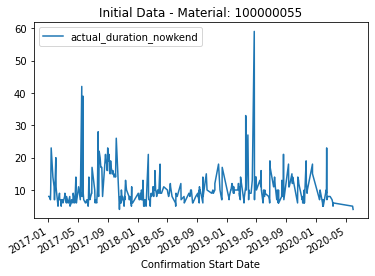

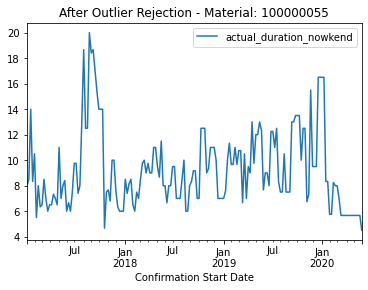

In [53]:
#Taking random group to test ARIMA models on
# 100001520
name = mats_trim[0]
#name = 100001520
sub = mat_trend_trim[name]
old = mat_trend[name]
display(deltas[0].loc[deltas[0]['Material'] == name])
display(old.plot(y = 'actual_duration_nowkend', title = "Initial Data - Material: %d" % name))
display(sub.plot(y = 'actual_duration_nowkend', title = "After Outlier Rejection - Material: %d" % name))

In [13]:
# Time-series data for model
ts = pd.Series(sub['actual_duration_nowkend'].values, index = sub.index)

In [14]:
# Array of external variables
exog_df = pd.DataFrame(sub['Total order quantity'])

# Filling in null values in data 
exog_df = exog_df.fillna(method = "ffill")

# Convert to values for arima model
exog_arr = exog_df.values

In [15]:
# Splitting data into test/train
ratio = 0.8
length = ts.shape[0]
pivot = int(ratio * length)
endpivot = length - pivot

ts_train = ts[:pivot]
ts_test = ts[pivot:]

exog_train = exog_arr[:pivot]
exog_test = exog_arr[pivot:]

dates_train = ts[:pivot]
dates_test = ts[pivot:]

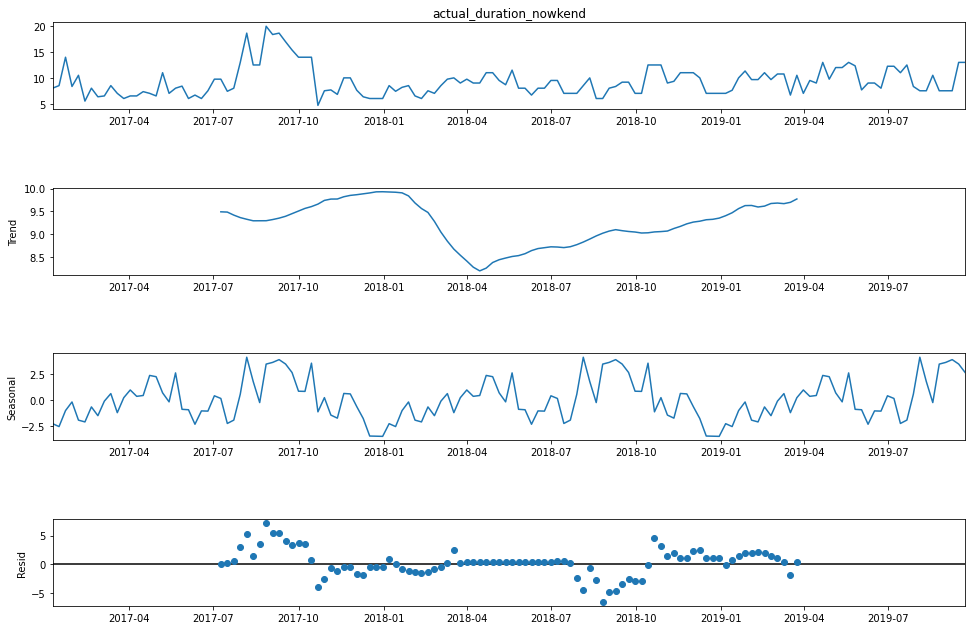

In [16]:
# plot of training data
res = sm.tsa.seasonal_decompose(sub["actual_duration_nowkend"][:pivot], model = "additive")
fig = res.plot()
fig.set_figheight(10)
fig.set_figwidth(15)
plt.show()

## ARIMA MODELLING TESTING

### Auto-Arima

In [ ]:
# Fitting
arima = pm.auto_arima(ts_train, exog_train, m=12, seasonal=True, trace=True, error_action='ignore', suppress_warnings = True, stepwise=True)
arima2 = pm.auto_arima(ts_train, exog_train, d=1, error_action='ignore', suppress_warnings = True)
arima3 = pm.auto_arima(ts_train, seasonal=True, error_action='ignore', suppress_warnings = True)

In [ ]:
display(arima.summary())
display(arima2.summary())
display(arima3.summary())

In [48]:
arima.fit(ts_train, exog_train)
arima2.fit(ts_train, exog_train)
arima3.fit(ts_train)

ARIMA(order=(1, 0, 1), suppress_warnings=True)

### Manual Fit

In [18]:
# dataframe of trials
trials = pd.DataFrame(columns = ['aic', 'mse', 'p', 'd', 'q', 'P', 'D','Q'])

In [ ]:
trial_list = []
champaic = 10000
# values to check
p_vals = [0]
d_vals = [0, 1]
q_vals = [0]

P_vals = [0,1,2,3,4]
D_vals = [0,1,2]
Q_vals = [0,1,2,3,4]
s_vals = [4,6,12]

# iterates through all possible combinations
for s in s_vals:
    for P in P_vals:
        for D in D_vals:
            for Q in Q_vals:
                for p in p_vals:
                    for d in d_vals:
                        for q in q_vals:
                            # model fit / forecast
                            model = pm.arima.ARIMA((p,d,q), seasonal_order=(P, D, Q, s), suppress_warnings = True)
                            model.fit(ts_train)
                            forecast = model.predict(n_periods = ts_test.shape[0])
                            # metrics
                            mse = mean_squared_error(ts_test, forecast)
                            aic = model.aic()
                            if aic < champaic:
                                champaic = aic
                            trial_list.append([aic,mse,p,d,q,P,D,Q,s])
trials = pd.DataFrame(trial_list, columns = ['aic','mse', 'p','d','q', 'P','D','Q', 's']).sort_values(by = ['aic', 'mse'])
display(champaic)
trials

In [ ]:
trials[trials['aic']==trials['aic'].min()]
# trials.groupby(['q']).mean() 

In [42]:
# fit model
man_arima = pm.arima.ARIMA((0, 1, 0), (0,1,3,12), suppress_warnings = True)
man_arima.fit(ts_train)

ARIMA(order=(0, 1, 0), seasonal_order=(0, 1, 3, 12), suppress_warnings=True)

## RESULTS

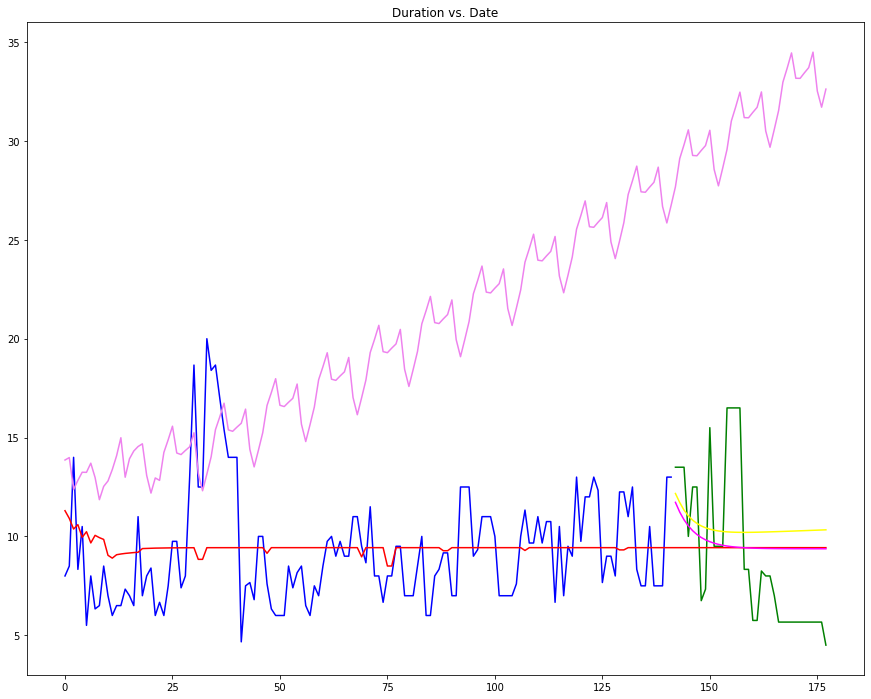

In [49]:
num_test = ts_test.shape[0]

# forecasts - uncomment depending on what you're using
forecasts = arima.predict(n_periods = length, exogenous = exog_arr)  
forecasts2 = arima2.predict(n_periods = num_test, exogenous = exog_test)
forecasts3 = arima3.predict(n_periods = num_test)
forecasts4 = man_arima.predict(n_periods = length, exogenous = exog_arr)

# Visualize the forecasts (blue=train, green=test)
x = np.arange(length)
plt.plot(x[:pivot], ts_train, c='blue')
plt.plot(x[pivot:], ts_test, c = 'green')
plt.plot(x[:], forecasts, c='red')
plt.plot(x[pivot:], forecasts2, c='yellow')
plt.plot(x[pivot:], forecasts3, c='magenta')
plt.plot(x[:], forecasts4, c='violet')
plt.gcf().set_size_inches(15, 12)
plt.title('Duration vs. Date')
plt.show()


In [50]:
error = mean_squared_error(ts, forecasts)
error2 = mean_squared_error(ts_test, forecasts2)
error3 = mean_squared_error(ts_test, forecasts3)
error4 = mean_squared_error(ts, forecasts4)
print('Test MSE: %.3f' % error)
print('Test2 MSE: %.3f' % error2)
print('Test3 MSE: %.3f' % error3)
print('Test4 MSE: %.3f' % error4)

Test MSE: 9.544
Test2 MSE: 15.742
Test3 MSE: 13.573
Test4 MSE: 204.313


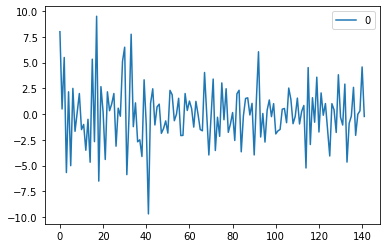

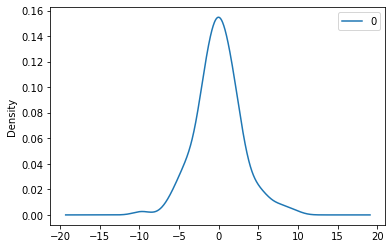

                0
count  142.000000
mean     0.025155
std      2.877412
min     -9.688384
25%     -1.629628
50%     -0.028658
75%      1.545011
max      9.493769


In [45]:
residuals = pd.DataFrame(man_arima.resid())
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

## ARIMA MODELLING AUTOMATED OVER MATERIALS

In [69]:
# Very messy / not concise code - just for a quick test
test_list = []
# testing 
for mat in mats_trim:
    sub = mat_trend_trim[mat]
    # Time-series data for model
    ts = pd.Series(sub['actual_duration_nowkend'].values, index = sub.index)
    # Array of external variables
    exog_df = pd.DataFrame(sub['Total order quantity'])

    # Filling in null values in data 
    exog_df = exog_df.fillna(method = "ffill")

    # Convert to values for arima model
    exog_arr = exog_df.values
    
    # Splitting data into test/train
    ratio = 0.8
    length = ts.shape[0]
    pivot = int(ratio * length)
    endpivot = length - pivot

    ts_train = ts[:pivot]
    ts_test = ts[pivot:]

    exog_train = exog_arr[:pivot]
    exog_test = exog_arr[pivot:]
    
    # modelling
    model1 = pm.auto_arima(ts_train, exog_train, m=12, seasonal=True, trace=True, error_action='ignore', suppress_warnings = True, stepwise=True)
    model2 = pm.auto_arima(ts_train, exog_train, d=1, error_action='ignore', suppress_warnings = True)
    model3 = pm.auto_arima(ts_train, m=12, seasonal=True, error_action='ignore', suppress_warnings = True)
       
    model1.fit(ts_train, exog_train)
    model2.fit(ts_train, exog_train)
    model3.fit(ts_train)
   
    forecast1 = model1.predict(n_periods = ts_test.shape[0], exogenous = exog_test)
    forecast2 = model2.predict(n_periods = ts_test.shape[0], exogenous = exog_test)
    forecast3 = model3.predict(n_periods = ts_test.shape[0])
    
    mse1 = mean_squared_error(ts_test, forecast1)
    mse2 = mean_squared_error(ts_test, forecast2)
    mse3 = mean_squared_error(ts_test, forecast3)
    
    aic1 = model1.aic()
    aic2 = model2.aic()
    aic3 = model3.aic()
    
    
    test_list.append([mat,1,aic1,mse1])
    test_list.append([mat,2,aic2,mse2])
    test_list.append([mat,3,aic3,mse3])
tests = pd.DataFrame(test_list, columns = ['mat','model','aic', 'mse']).sort_values(by = ['aic', 'mse'])
tests

Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(1,0,1,12) [intercept=True]; AIC=634.733, BIC=661.335, Time=1.759 seconds
Fit ARIMA(0,0,0)x(0,0,0,12) [intercept=True]; AIC=704.696, BIC=713.564, Time=0.139 seconds
Fit ARIMA(1,0,0)x(1,0,0,12) [intercept=True]; AIC=630.069, BIC=644.848, Time=0.573 seconds
Fit ARIMA(0,0,1)x(0,0,1,12) [intercept=True]; AIC=655.422, BIC=670.202, Time=0.629 seconds
Fit ARIMA(0,0,0)x(0,0,0,12) [intercept=False]; AIC=702.698, BIC=708.609, Time=0.214 seconds
Fit ARIMA(1,0,0)x(0,0,0,12) [intercept=True]; AIC=629.849, BIC=641.672, Time=0.058 seconds
Fit ARIMA(1,0,0)x(0,0,1,12) [intercept=True]; AIC=631.062, BIC=645.841, Time=0.246 seconds
Fit ARIMA(1,0,0)x(1,0,1,12) [intercept=True]; AIC=633.292, BIC=651.027, Time=0.362 seconds
Fit ARIMA(2,0,0)x(0,0,0,12) [intercept=True]; AIC=628.493, BIC=643.272, Time=0.071 seconds
Fit ARIMA(2,0,0)x(1,0,0,12) [intercept=True]; AIC=628.908, BIC=646.643, Time=0.493 seconds
Fit ARIMA(2,0,0)x(0,0,1,12) [intercept=True]; 

Fit ARIMA(1,0,1)x(0,0,0,12) [intercept=True]; AIC=919.478, BIC=934.186, Time=0.383 seconds
Fit ARIMA(1,0,1)x(1,0,0,12) [intercept=True]; AIC=925.465, BIC=943.115, Time=0.817 seconds
Fit ARIMA(1,0,1)x(0,0,1,12) [intercept=True]; AIC=957.823, BIC=975.473, Time=0.307 seconds
Fit ARIMA(1,0,1)x(1,0,1,12) [intercept=True]; AIC=959.997, BIC=980.588, Time=0.343 seconds
Fit ARIMA(0,0,1)x(0,0,0,12) [intercept=True]; AIC=992.324, BIC=1004.091, Time=0.101 seconds
Fit ARIMA(1,0,0)x(0,0,0,12) [intercept=True]; AIC=915.606, BIC=927.373, Time=0.252 seconds
Fit ARIMA(1,0,0)x(0,0,1,12) [intercept=True]; AIC=955.540, BIC=970.248, Time=0.245 seconds
Fit ARIMA(1,0,0)x(1,0,1,12) [intercept=True]; AIC=957.700, BIC=975.350, Time=0.659 seconds
Fit ARIMA(2,0,0)x(0,0,0,12) [intercept=True]; AIC=920.404, BIC=935.112, Time=0.812 seconds
Fit ARIMA(2,0,1)x(0,0,0,12) [intercept=True]; AIC=935.999, BIC=953.648, Time=1.196 seconds
Total fit time: 10.727 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2

/opt/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


Fit ARIMA(2,1,0)x(0,0,0,12) [intercept=True]; AIC=660.002, BIC=674.378, Time=0.148 seconds
Fit ARIMA(3,1,1)x(0,0,0,12) [intercept=True]; AIC=650.447, BIC=670.574, Time=0.203 seconds
Fit ARIMA(1,1,0)x(0,0,0,12) [intercept=True]; AIC=680.543, BIC=692.044, Time=0.250 seconds
Fit ARIMA(1,1,2)x(0,0,0,12) [intercept=True]; AIC=650.113, BIC=667.364, Time=0.171 seconds
Fit ARIMA(3,1,0)x(0,0,0,12) [intercept=True]; AIC=652.277, BIC=669.528, Time=0.172 seconds
Fit ARIMA(3,1,2)x(0,0,0,12) [intercept=True]; AIC=713.078, BIC=736.079, Time=0.213 seconds
Total fit time: 8.195 seconds


/opt/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1886: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/opt/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/opt/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/opt/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1886: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/opt/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1893: RuntimeWarning: divide by zero encountered in reciprocal


Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(1,0,1,12) [intercept=True]; AIC=739.209, BIC=765.554, Time=1.168 seconds
Fit ARIMA(0,1,0)x(0,0,0,12) [intercept=True]; AIC=746.096, BIC=754.878, Time=0.081 seconds
Fit ARIMA(1,1,0)x(1,0,0,12) [intercept=True]; AIC=740.295, BIC=754.932, Time=0.490 seconds
Fit ARIMA(0,1,1)x(0,0,1,12) [intercept=True]; AIC=740.190, BIC=754.826, Time=0.501 seconds
Fit ARIMA(0,1,0)x(0,0,0,12) [intercept=False]; AIC=1287.065, BIC=1292.919, Time=0.033 seconds
Fit ARIMA(2,1,2)x(0,0,1,12) [intercept=True]; AIC=728.792, BIC=752.210, Time=1.158 seconds
Fit ARIMA(2,1,2)x(0,0,0,12) [intercept=True]; AIC=756.485, BIC=776.976, Time=0.185 seconds
Fit ARIMA(2,1,2)x(0,0,2,12) [intercept=True]; AIC=746.828, BIC=773.173, Time=2.366 seconds
Fit ARIMA(2,1,2)x(1,0,0,12) [intercept=True]; AIC=735.298, BIC=758.716, Time=0.909 seconds
Fit ARIMA(2,1,2)x(1,0,2,12) [intercept=True]; AIC=741.517, BIC=770.790, Time=2.664 seconds
Fit ARIMA(1,1,2)x(0,0,1,12) [intercept=True]

/opt/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1886: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/opt/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(1,0,1,12) [intercept=True]; AIC=863.902, BIC=889.916, Time=1.494 seconds
Fit ARIMA(0,0,0)x(0,0,0,12) [intercept=True]; AIC=1029.607, BIC=1038.278, Time=0.111 seconds
Fit ARIMA(1,0,0)x(1,0,0,12) [intercept=True]; AIC=851.427, BIC=865.879, Time=1.036 seconds
Fit ARIMA(0,0,1)x(0,0,1,12) [intercept=True]; AIC=938.852, BIC=953.304, Time=0.936 seconds
Fit ARIMA(0,0,0)x(0,0,0,12) [intercept=False]; AIC=1027.691, BIC=1033.472, Time=0.108 seconds
Fit ARIMA(1,0,0)x(0,0,0,12) [intercept=True]; AIC=848.856, BIC=860.417, Time=0.542 seconds
Fit ARIMA(1,0,0)x(0,0,1,12) [intercept=True]; AIC=851.780, BIC=866.231, Time=1.061 seconds
Fit ARIMA(1,0,0)x(1,0,1,12) [intercept=True]; AIC=853.472, BIC=870.815, Time=0.913 seconds
Fit ARIMA(2,0,0)x(0,0,0,12) [intercept=True]; AIC=850.853, BIC=865.305, Time=0.327 seconds
Fit ARIMA(1,0,1)x(0,0,0,12) [intercept=True]; AIC=850.837, BIC=865.289, Time=0.289 seconds
Fit ARIMA(0,0,1)x(0,0,0,12) [intercept=Tru

/opt/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1886: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/opt/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(1,0,1,12) [intercept=True]; AIC=904.295, BIC=930.770, Time=0.852 seconds
Fit ARIMA(0,1,0)x(0,0,0,12) [intercept=True]; AIC=881.776, BIC=890.601, Time=0.081 seconds
Fit ARIMA(1,1,0)x(1,0,0,12) [intercept=True]; AIC=872.165, BIC=886.873, Time=0.241 seconds
Fit ARIMA(0,1,1)x(0,0,1,12) [intercept=True]; AIC=872.118, BIC=886.826, Time=0.428 seconds
Fit ARIMA(0,1,0)x(0,0,0,12) [intercept=False]; AIC=1432.625, BIC=1438.508, Time=0.057 seconds
Fit ARIMA(0,1,1)x(0,0,0,12) [intercept=True]; AIC=866.005, BIC=877.771, Time=0.113 seconds
Fit ARIMA(0,1,1)x(1,0,0,12) [intercept=True]; AIC=867.463, BIC=882.171, Time=0.176 seconds
Fit ARIMA(0,1,1)x(1,0,1,12) [intercept=True]; AIC=874.239, BIC=891.889, Time=0.364 seconds
Fit ARIMA(1,1,1)x(0,0,0,12) [intercept=True]; AIC=864.204, BIC=878.912, Time=0.122 seconds
Fit ARIMA(1,1,1)x(1,0,0,12) [intercept=True]; AIC=865.672, BIC=883.322, Time=0.650 seconds
Fit ARIMA(1,1,1)x(0,0,1,12) [intercept=True]

Fit ARIMA(3,1,3)x(0,0,2,12) [intercept=True]; AIC=561.168, BIC=593.447, Time=3.571 seconds
Near non-invertible roots for order (3, 1, 3)(0, 0, 2, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 27.578 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(1,0,1,12) [intercept=True]; AIC=680.464, BIC=706.939, Time=0.640 seconds
Fit ARIMA(0,0,0)x(0,0,0,12) [intercept=True]; AIC=754.086, BIC=762.911, Time=0.063 seconds
Fit ARIMA(1,0,0)x(1,0,0,12) [intercept=True]; AIC=679.218, BIC=693.926, Time=0.112 seconds
Fit ARIMA(0,0,1)x(0,0,1,12) [intercept=True]; AIC=706.486, BIC=721.194, Time=0.195 seconds
Fit ARIMA(0,0,0)x(0,0,0,12) [intercept=False]; AIC=752.086, BIC=757.969, Time=0.045 seconds
Fit ARIMA(1,0,0)x(0,0,0,12) [intercept=True]; AIC=677.220, BIC=688.987, Time=0.034 seconds
Fit ARIMA(1,0,0)x(0,0,1,12) [intercept=True]; AIC=679.218, BIC=693.926, Time=0.090 seconds
Fit ARIMA(1,0,0)x(1,0,1,12) [intercept

Fit ARIMA(2,0,2)x(1,0,1,12) [intercept=True]; AIC=655.440, BIC=681.979, Time=1.122 seconds
Fit ARIMA(0,0,0)x(0,0,0,12) [intercept=True]; AIC=702.098, BIC=710.944, Time=0.057 seconds
Fit ARIMA(1,0,0)x(1,0,0,12) [intercept=True]; AIC=657.020, BIC=671.764, Time=0.292 seconds
Fit ARIMA(0,0,1)x(0,0,1,12) [intercept=True]; AIC=663.579, BIC=678.323, Time=0.344 seconds
Fit ARIMA(0,0,0)x(0,0,0,12) [intercept=False]; AIC=700.099, BIC=705.997, Time=0.091 seconds
Fit ARIMA(2,0,2)x(0,0,1,12) [intercept=True]; AIC=649.736, BIC=673.326, Time=1.121 seconds
Fit ARIMA(2,0,2)x(0,0,0,12) [intercept=True]; AIC=651.796, BIC=672.438, Time=0.363 seconds
Fit ARIMA(2,0,2)x(0,0,2,12) [intercept=True]; AIC=657.352, BIC=683.891, Time=2.314 seconds
Fit ARIMA(2,0,2)x(1,0,0,12) [intercept=True]; AIC=649.494, BIC=673.084, Time=1.075 seconds
Fit ARIMA(2,0,2)x(2,0,0,12) [intercept=True]; AIC=655.655, BIC=682.193, Time=2.191 seconds
Fit ARIMA(2,0,2)x(2,0,1,12) [intercept=True]; AIC=655.678, BIC=685.165, Time=3.664 second

Fit ARIMA(1,0,0)x(0,0,0,12) [intercept=True]; AIC=659.032, BIC=670.623, Time=0.257 seconds
Fit ARIMA(1,0,0)x(2,0,0,12) [intercept=True]; AIC=667.750, BIC=685.137, Time=1.370 seconds
Fit ARIMA(1,0,0)x(1,0,1,12) [intercept=True]; AIC=660.221, BIC=677.608, Time=1.141 seconds
Fit ARIMA(1,0,0)x(0,0,1,12) [intercept=True]; AIC=665.216, BIC=679.706, Time=0.336 seconds
Fit ARIMA(1,0,0)x(2,0,1,12) [intercept=True]; AIC=661.355, BIC=681.640, Time=1.549 seconds
Fit ARIMA(0,0,0)x(1,0,0,12) [intercept=True]; AIC=869.865, BIC=881.456, Time=0.134 seconds
Fit ARIMA(2,0,0)x(1,0,0,12) [intercept=True]; AIC=666.503, BIC=683.890, Time=0.583 seconds
Fit ARIMA(1,0,1)x(1,0,0,12) [intercept=True]; AIC=665.231, BIC=682.618, Time=0.521 seconds
Fit ARIMA(0,0,1)x(1,0,0,12) [intercept=True]; AIC=778.912, BIC=793.402, Time=0.280 seconds
Fit ARIMA(2,0,1)x(1,0,0,12) [intercept=True]; AIC=668.047, BIC=688.332, Time=0.735 seconds
Total fit time: 9.276 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x

Fit ARIMA(1,0,1)x(0,0,0,12) [intercept=True]; AIC=548.576, BIC=562.472, Time=0.213 seconds
Fit ARIMA(0,0,1)x(0,0,0,12) [intercept=True]; AIC=578.318, BIC=589.435, Time=0.162 seconds
Fit ARIMA(2,0,1)x(0,0,0,12) [intercept=True]; AIC=549.565, BIC=566.240, Time=0.273 seconds
Total fit time: 3.421 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(1,0,1,12) [intercept=True]; AIC=504.019, BIC=528.955, Time=0.870 seconds
Fit ARIMA(0,0,0)x(0,0,0,12) [intercept=True]; AIC=594.443, BIC=602.755, Time=0.224 seconds
Fit ARIMA(1,0,0)x(1,0,0,12) [intercept=True]; AIC=490.712, BIC=504.566, Time=0.495 seconds
Fit ARIMA(0,0,1)x(0,0,1,12) [intercept=True]; AIC=531.212, BIC=545.066, Time=0.654 seconds
Fit ARIMA(0,0,0)x(0,0,0,12) [intercept=False]; AIC=603.815, BIC=609.356, Time=0.118 seconds
Fit ARIMA(1,0,0)x(0,0,0,12) [intercept=True]; AIC=490.250, BIC=501.333, Time=0.160 seconds
Fit ARIMA(1,0,0)x(0,0,1,12) [intercept=True]; AIC=490.981, BIC=504.835, Time=0.493 seconds
Fit ARIMA(1,0,0)

Fit ARIMA(0,1,1)x(0,0,1,12) [intercept=True]; AIC=730.831, BIC=745.539, Time=0.280 seconds
Fit ARIMA(0,1,0)x(0,0,0,12) [intercept=False]; AIC=1299.072, BIC=1304.955, Time=0.047 seconds
Fit ARIMA(0,1,1)x(0,0,0,12) [intercept=True]; AIC=726.353, BIC=738.120, Time=0.094 seconds
Fit ARIMA(0,1,1)x(1,0,0,12) [intercept=True]; AIC=728.259, BIC=742.967, Time=0.229 seconds
Fit ARIMA(0,1,1)x(1,0,1,12) [intercept=True]; AIC=732.726, BIC=750.376, Time=0.340 seconds
Fit ARIMA(1,1,1)x(0,0,0,12) [intercept=True]; AIC=719.647, BIC=734.356, Time=0.118 seconds
Fit ARIMA(1,1,1)x(1,0,0,12) [intercept=True]; AIC=721.587, BIC=739.236, Time=0.272 seconds
Fit ARIMA(1,1,1)x(0,0,1,12) [intercept=True]; AIC=724.009, BIC=741.659, Time=0.277 seconds
Fit ARIMA(1,1,1)x(1,0,1,12) [intercept=True]; AIC=725.932, BIC=746.523, Time=0.336 seconds
Fit ARIMA(1,1,0)x(0,0,0,12) [intercept=True]; AIC=734.780, BIC=746.547, Time=0.110 seconds
Fit ARIMA(2,1,1)x(0,0,0,12) [intercept=True]; AIC=757.016, BIC=774.665, Time=0.136 seco

/opt/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1886: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/opt/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


Fit ARIMA(1,1,2)x(0,0,0,12) [intercept=True]; AIC=709.887, BIC=727.537, Time=0.317 seconds
Fit ARIMA(1,1,2)x(1,0,0,12) [intercept=True]; AIC=711.961, BIC=732.553, Time=0.662 seconds
Fit ARIMA(1,1,2)x(0,0,1,12) [intercept=True]; AIC=714.858, BIC=735.450, Time=0.294 seconds
Fit ARIMA(1,1,2)x(1,0,1,12) [intercept=True]; AIC=716.783, BIC=740.316, Time=0.341 seconds
Fit ARIMA(0,1,2)x(0,0,0,12) [intercept=True]; AIC=714.681, BIC=729.389, Time=0.158 seconds
Fit ARIMA(2,1,2)x(0,0,0,12) [intercept=True]; AIC=813.646, BIC=834.238, Time=0.155 seconds


/opt/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


Fit ARIMA(1,1,3)x(0,0,0,12) [intercept=True]; AIC=709.733, BIC=730.324, Time=0.342 seconds
Fit ARIMA(1,1,3)x(1,0,0,12) [intercept=True]; AIC=712.170, BIC=735.704, Time=0.637 seconds
Fit ARIMA(1,1,3)x(0,0,1,12) [intercept=True]; AIC=715.510, BIC=739.044, Time=0.811 seconds
Fit ARIMA(1,1,3)x(1,0,1,12) [intercept=True]; AIC=717.528, BIC=744.003, Time=0.897 seconds
Fit ARIMA(0,1,3)x(0,0,0,12) [intercept=True]; AIC=707.617, BIC=725.266, Time=0.285 seconds
Fit ARIMA(0,1,3)x(1,0,0,12) [intercept=True]; AIC=710.014, BIC=730.606, Time=0.562 seconds
Fit ARIMA(0,1,3)x(0,0,1,12) [intercept=True]; AIC=713.830, BIC=734.422, Time=0.664 seconds
Fit ARIMA(0,1,3)x(1,0,1,12) [intercept=True]; AIC=715.778, BIC=739.311, Time=0.799 seconds
Fit ARIMA(0,1,4)x(0,0,0,12) [intercept=True]; AIC=709.023, BIC=729.615, Time=0.341 seconds
Fit ARIMA(1,1,4)x(0,0,0,12) [intercept=True]; AIC=710.268, BIC=733.801, Time=0.188 seconds
Total fit time: 10.445 seconds


/opt/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1886: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/opt/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(1,0,1,12) [intercept=True]; AIC=917.617, BIC=943.830, Time=1.003 seconds
Fit ARIMA(0,0,0)x(0,0,0,12) [intercept=True]; AIC=1061.051, BIC=1069.789, Time=0.050 seconds
Fit ARIMA(1,0,0)x(1,0,0,12) [intercept=True]; AIC=913.576, BIC=928.140, Time=0.189 seconds
Fit ARIMA(0,0,1)x(0,0,1,12) [intercept=True]; AIC=965.166, BIC=979.729, Time=0.496 seconds
Fit ARIMA(0,0,0)x(0,0,0,12) [intercept=False]; AIC=1059.170, BIC=1064.996, Time=0.079 seconds
Fit ARIMA(1,0,0)x(0,0,0,12) [intercept=True]; AIC=912.190, BIC=923.841, Time=0.143 seconds
Fit ARIMA(1,0,0)x(0,0,1,12) [intercept=True]; AIC=912.303, BIC=926.867, Time=0.587 seconds
Fit ARIMA(1,0,0)x(1,0,1,12) [intercept=True]; AIC=912.790, BIC=930.266, Time=0.604 seconds
Fit ARIMA(2,0,0)x(0,0,0,12) [intercept=True]; AIC=913.143, BIC=927.706, Time=0.080 seconds
Fit ARIMA(1,0,1)x(0,0,0,12) [intercept=True]; AIC=910.942, BIC=925.505, Time=0.269 seconds
Fit ARIMA(1,0,1)x(1,0,0,12) [intercept=Tru

Fit ARIMA(2,1,1)x(0,0,0,12) [intercept=True]; AIC=551.382, BIC=569.074, Time=0.610 seconds
Fit ARIMA(1,1,2)x(0,0,0,12) [intercept=True]; AIC=556.253, BIC=573.945, Time=0.409 seconds
Fit ARIMA(0,1,2)x(0,0,0,12) [intercept=True]; AIC=554.201, BIC=568.944, Time=0.953 seconds
Fit ARIMA(2,1,0)x(0,0,0,12) [intercept=True]; AIC=554.654, BIC=569.398, Time=0.393 seconds
Fit ARIMA(2,1,2)x(0,0,0,12) [intercept=True]; AIC=551.926, BIC=572.567, Time=0.906 seconds
Total fit time: 9.448 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(1,0,1,12) [intercept=True]; AIC=1140.550, BIC=1165.637, Time=1.679 seconds
Fit ARIMA(0,0,0)x(0,0,0,12) [intercept=True]; AIC=1366.125, BIC=1374.487, Time=0.067 seconds
Fit ARIMA(1,0,0)x(1,0,0,12) [intercept=True]; AIC=1128.119, BIC=1142.057, Time=0.655 seconds
Fit ARIMA(0,0,1)x(0,0,1,12) [intercept=True]; AIC=1295.428, BIC=1309.365, Time=0.460 seconds
Fit ARIMA(0,0,0)x(0,0,0,12) [intercept=False]; AIC=1832.151, BIC=1837.726, Time=0.016 seconds
Fit AR

,mat,model,aic,mse
104,100001910,3,435.101737,1.500000
103,100001910,2,437.101737,1.500000
102,100001910,1,444.339041,2.966939
143,100002534,3,452.528542,8.080687
142,100002534,2,454.242519,13.962487
...,...,...,...,...
12,100000339,1,915.606433,12.027663
13,100000339,2,918.618474,18.830435
140,100002361,3,1114.259003,775.461587
138,100002361,1,1126.619466,662.926870


In [78]:
# Prints out minimum MSE per material (minimum of three models tested on each material)
mins = tests.groupby(['mat'])['mse'].min()
mins

mat
100000055     13.572675
100000197      8.271731
100000257     22.264560
100000338     52.745990
100000339     12.027663
100000340     46.706639
100000341     17.014526
100000344     86.244495
100000453     88.452040
100000519     24.672730
100000636     22.157805
100000699     46.502853
100000762     51.750770
100000794     73.632474
100000934     16.577857
100001062     59.040209
100001064      2.848881
100001065     22.915039
100001068      3.527668
100001070      5.721953
100001074      7.788352
100001078      8.077071
100001471     24.664534
100001489      6.810890
100001520     12.721478
100001521     81.562586
100001522     48.362102
100001523     30.342172
100001705     25.550602
100001709     24.396435
100001902     18.141918
100001903     19.398480
100001905     11.507263
100001908      3.453890
100001910      1.500000
100001916      3.031867
100001919      5.884620
100001921     14.908333
100001923     40.964224
100001958     55.407438
100001998    122.578926
100002026   

In [84]:
# Median/min
print("Over all materials: ")
print("Median MSE: %d" % mins.median())
print("Average MSE: %d" % mins.mean())

Over all materials: 
Median MSE: 22
Average MSE: 34
